### Import the necessary libraries

In [15]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.inspection import permutation_importance

### Read data

In [3]:
df = gpd.read_file('../data/processed/final_combined_divisions/final_combined_divisions.shp')

### Feature engineering

In [4]:
#convert District to factor
df['District'] = df['District'].astype('category')
df['District'] = df['District'].cat.codes

In [5]:
df.head()

,District,x,y,Year,Area_sq_km,HDI,Cases,Population,Pop_den,geometry
0,0,107.610841,-7.099969,2020,1767.96,72.39,9180,14495160,8198.805403,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
1,0,107.610841,-7.099969,2021,1767.96,72.73,8008,14662620,8293.524740,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
2,0,107.610841,-7.099969,2022,1767.96,73.16,16764,14830092,8388.250865,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
3,0,107.610841,-7.099969,2023,1767.96,73.74,4020,14997564,8482.976990,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427..."
4,1,107.414953,-6.897056,2020,1305.77,68.08,3864,7153344,5478.257273,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688..."


In [ ]:
# Load your dataset
# df = pd.read_csv("your_data.csv")  # Uncomment if loading from CSV

# Define features and target
X = df.drop(columns= ['Cases', "geometry"])  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on both 'District' and 'Year'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Compute Permutation Importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Convert to DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print(importance_df)

#population is most important, but since it is an absolute number, can just include population density, and hdi. 

      Feature  Importance
6  Population    0.445418
7     Pop_den    0.227904
5         HDI    0.046144
2           y    0.007498
3        Year    0.005940
0    District    0.003770
4  Area_sq_km   -0.028009
1           x   -0.028120


In [24]:
#fit random forest model
X = df[['Pop_den', "HDI"]]  # Features
feature_names =  X.columns.tolist()
y = df['Cases']

# Stratify based on both 'District' and 'Year'
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42)

# Now you have train_index and test_index containing the original indices
# of the rows that went into training and testing sets respectively.

In [25]:
#OOB error to find the optimal n_estimators, with 500, 1000 trees; (dont need to tune max_features first)
# Define your random forest regressor
rf = RandomForestRegressor(oob_score=True, random_state=42)

# Set up the grid search parameters for n_estimators
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Adjust as needed
}

# Set up GridSearchCV with oob_score
grid_search = GridSearchCV(rf, param_grid, cv=None, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best number of trees (n_estimators)
best_n_estimators = grid_search.best_params_['n_estimators']
print(f"Optimal n_estimators: {best_n_estimators}")

# Access the best OOB score
best_oob_score = grid_search.best_estimator_.oob_score_
print(f"Best OOB score: {best_oob_score}")

Optimal n_estimators: 500
Best OOB score: 0.47412765809335977


In [26]:
#compute the predictions and then append the predictions to the df, then extract the df out
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
# Add the predictions to the test set (preserving indices)
X_test['Predicted_Cases'] = y_pred

# Now merge predictions back to the original dataframe using the indices of X_test
df_with_predictions = pd.merge(df, X_test[['Predicted_Cases']],
                                left_index=True, right_index=True, how='left')

# Show the dataframe with predictions included
print(df_with_predictions)

    District           x         y  Year  Area_sq_km    HDI  Cases  \
0          0  107.610841 -7.099969  2020     1767.96  72.39   9180   
1          0  107.610841 -7.099969  2021     1767.96  72.73   8008   
2          0  107.610841 -7.099969  2022     1767.96  73.16  16764   
3          0  107.610841 -7.099969  2023     1767.96  73.74   4020   
4          1  107.414953 -6.897056  2020     1305.77  68.08   3864   
..       ...         ...       ...   ...         ...    ...    ...   
91        22  107.980850 -6.825066  2023     1518.33  73.18   5232   
92        23  108.141296 -7.496706  2020     2551.19  65.67    716   
93        23  108.141296 -7.496706  2021     2551.19  65.90    188   
94        23  108.141296 -7.496706  2022     2551.19  66.84   1276   
95        23  108.141296 -7.496706  2023     2551.19  67.76    352   

    Population      Pop_den  \
0     14495160  8198.805403   
1     14662620  8293.524740   
2     14830092  8388.250865   
3     14997564  8482.976990   
4   

In [ ]:
#save the df with predictions
df_with_predictions.to_csv("../data/processed/df_combined_with_predictions_rf_popden_hdi.csv")

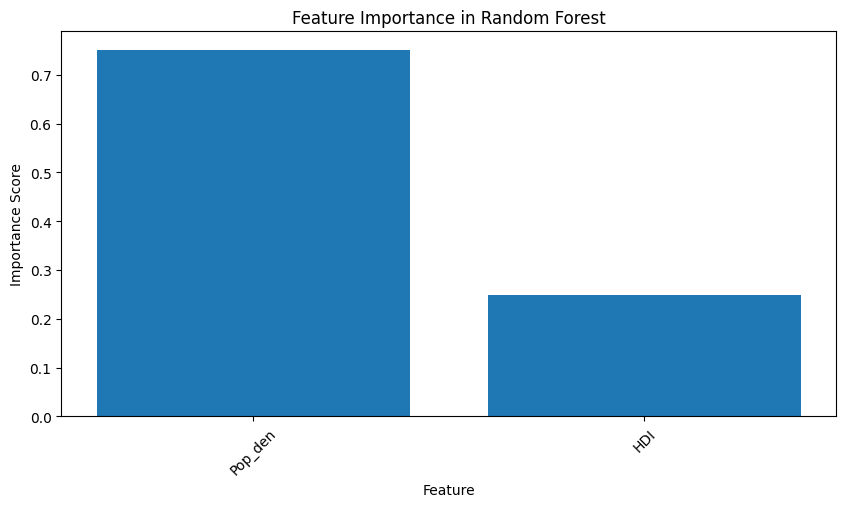

In [28]:
# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.show()

In [29]:
# Save the model
with open("../model_weights/rf/random_forest_model_pop_den_hdi.pkl", "wb") as f:
    pickle.dump(rf, f)

# Load the model
#with open("random_forest_model.pkl", "rb") as f:
#    rf_loaded = pickle.load(f)